# Import Libraries
**NOTE:** Rename this file to your CIT student number - i.e., replace XXXXXX 

In [3]:
import pandas as pd
import mysql.connector
import numpy as np
from sqlalchemy import create_engine

%matplotlib inline

import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [4]:
# master foldername
folder = 'H:\\Data8001\\Labs\\Datasets\\'

# Load Data & Create Master Dataset
1. Load sql data from CIT mysql database: **table name = data8001_assignment_2018**
2. Load mongo data from json file
3. Load Excel data from csv file
4. Align all column types & rename column headers to match sql data (see report index)
5. Create master dataframe joining sql, mongo & Excel data.

In [5]:
# first install the connector, open command prompt
# if using the default CIT Anaconda package
# conda install -y mysql-connector-python

In [6]:
mysql_host = 'com-db-02.student-cit.local'
mysql_user = 'python_db_user'
mysql_pwd = 'PythonDB'
mysql_db = 'data8001_2018'

# Create the sqlalchemy connection string
engine_string = 'mysql+mysqlconnector://%s:%s@%s/%s' % (mysql_user, mysql_pwd, mysql_host, mysql_db)

In [7]:
# Create the DB connection engine & connection
engine = create_engine(engine_string, echo=False)
conn = engine.raw_connection()

# This is a workaround to get data into SFrame via pandas data frame which is suppored by sqlalchemy
df_sql = pd.read_sql('SELECT * FROM data8001_assignment_2018', conn)

# Always close your connections
conn.close()

In [8]:
df_csv = pd.read_csv('{0}DATA8001_Assignment_2018_Data_csv.csv'.format(folder))
df_json = pd.read_json('{0}DATA8001_Assignment_2018_Data_mongo.json'.format(folder))
df_csv.head()

,Id,Surname,Credit Score,Location,Gender,Age,Years in Employment,Current Balance,Product Count,Has CC,Current Status,Current Salary,Still In Company
0,15612615,Graham,616,ireland,female,37 yrs,6 yrs,€0.00,2,1,0,"€86,242.18",0
1,15605835,Rice,743,ie,male,37,8,"€69,143.91",TWO,0,Active,"€105,780.18",0
2,15726250,Hsia,787,ireland,f,38,3,"€166,328.65",2,No,1,"€22,614.19",1
3,15676810,Jen,665,ie,1,31,1,"€81,480.27",TWO,1,Active,"€65,234.60",True
4,15691823,Obidimkpa,672,ie,0,37 yrs,5,"€153,195.59",1,1,Active,"€162,763.01",0


In [9]:
print('\n--- CSV ---')
print(df_csv.dtypes)
print('\n--- JSON ---')
print(df_json.dtypes)
print('\n--- SQL ---')
print(df_sql.dtypes)


--- CSV ---
Id                      int64
Surname                object
Credit Score            int64
Location               object
Gender                 object
Age                    object
Years in Employment    object
Current Balance        object
Product Count          object
Has CC                 object
Current Status         object
Current Salary         object
Still In Company       object
dtype: object

--- JSON ---
Age                  object
Balance              object
Country              object
Credit Card          object
Current Tenure       object
Cust_ID               int64
Estimated Salary     object
Existing Employee    object
Gender               object
Last Name            object
Products             object
Score                 int64
Status               object
dtype: object

--- SQL ---
customer_id       int64
surname          object
credit_score      int64
geography        object
gender           object
age              object
tenure           object
balance   

In [10]:
df_csv.rename(columns={'Id': 'customer_id'}, inplace=True)
df_csv.rename(columns={'Surname': 'surname'}, inplace=True)
df_csv.rename(columns={'Credit Score': 'credit_score'}, inplace=True)
df_csv.rename(columns={'Location': 'geography'}, inplace=True)
df_csv.rename(columns={'Gender': 'gender'}, inplace=True)
df_csv.rename(columns={'Age': 'age'}, inplace=True)
df_csv.rename(columns={'Years in Employment': 'tenure'}, inplace=True)
df_csv.rename(columns={'Current Balance': 'balance'}, inplace=True)
df_csv.rename(columns={'Product Count': 'num_products'}, inplace=True)
df_csv.rename(columns={'Has CC': 'credit_card'}, inplace=True)
df_csv.rename(columns={'Current Status': 'active_status'}, inplace=True)
df_csv.rename(columns={'Current Salary': 'salary_est'}, inplace=True)
df_csv.rename(columns={'Still In Company': 'exited'}, inplace=True)

In [11]:
df_json.rename(columns={'Cust_ID': 'customer_id'}, inplace=True)
df_json.rename(columns={'Last Name': 'surname'}, inplace=True)
df_json.rename(columns={'Score': 'credit_score'}, inplace=True)
df_json.rename(columns={'Country': 'geography'}, inplace=True)
df_json.rename(columns={'Gender': 'gender'}, inplace=True)
df_json.rename(columns={'Age': 'age'}, inplace=True)
df_json.rename(columns={'Current Tenure': 'tenure'}, inplace=True)
df_json.rename(columns={'Balance': 'balance'}, inplace=True)
df_json.rename(columns={'Products': 'num_products'}, inplace=True)
df_json.rename(columns={'Credit Card': 'credit_card'}, inplace=True)
df_json.rename(columns={'Status': 'active_status'}, inplace=True)
df_json.rename(columns={'Estimated Salary': 'salary_est'}, inplace=True)
df_json.rename(columns={'Existing Employee': 'exited'}, inplace=True)

In [12]:
"""
    get the numpy data type
"""
def get_type(dtype):
    if dtype == np.float16 or dtype == np.float32 or dtype == np.float64:
        return 'float'
    if dtype == np.int16 or dtype == np.int32 or dtype == np.int64:
        return 'int'
    if dtype == np.object:
        return 'str'

"""
    get the dataframe info, column name and data type
"""
def get_dataframe_info(df):
    # get the dataframe info as a series
    info = df.dtypes.to_frame('column_type_temp')
    # reset the df index
    info.reset_index(drop=False, inplace=True)
    # rename the column name
    info.rename(columns={'index':'column_name'}, inplace=True)
    # get the numpy data types inot new column
    info['column_type'] = info.apply(lambda x: get_type(x['column_type_temp']), axis=1)
    # subset of required columns
    info = info[['column_name','column_type']]
    # sort dataframe
    info.sort_values(by=['column_name','column_type'], ascending=True, inplace=True)
    # return the details as as dict
    return info.to_dict(orient='results')

In [13]:
# Test the function
print('\n--- CSV ---')
print(get_dataframe_info(df=df_csv))
print('\n--- JSON ---')
print(get_dataframe_info(df=df_json))
print('\n--- SQL ---')
print(get_dataframe_info(df=df_sql))


--- CSV ---
[{'column_name': 'active_status', 'column_type': 'str'}, {'column_name': 'age', 'column_type': 'str'}, {'column_name': 'balance', 'column_type': 'str'}, {'column_name': 'credit_card', 'column_type': 'str'}, {'column_name': 'credit_score', 'column_type': 'int'}, {'column_name': 'customer_id', 'column_type': 'int'}, {'column_name': 'exited', 'column_type': 'str'}, {'column_name': 'gender', 'column_type': 'str'}, {'column_name': 'geography', 'column_type': 'str'}, {'column_name': 'num_products', 'column_type': 'str'}, {'column_name': 'salary_est', 'column_type': 'str'}, {'column_name': 'surname', 'column_type': 'str'}, {'column_name': 'tenure', 'column_type': 'str'}]

--- JSON ---
[{'column_name': 'active_status', 'column_type': 'str'}, {'column_name': 'age', 'column_type': 'str'}, {'column_name': 'balance', 'column_type': 'str'}, {'column_name': 'credit_card', 'column_type': 'str'}, {'column_name': 'credit_score', 'column_type': 'int'}, {'column_name': 'customer_id', 'column

In [14]:
def dataframe_compare_column_info(df1, df2):
    valid = True
    infoA = get_dataframe_info(df=df1) # get the sorted column name & type of dataframe A
    infoB = get_dataframe_info(df=df2) # get the sorted column name & type of dataframe B
    
    # Create an empty list to store the results (if any).
    # Note: the list is empty with no size (length), unlike list in the get_sframe_column_info function?
    # this allows for a dynamic list to be created, appendign items as required
    result = []
     
    for i in range(len(infoA)):
        if infoA[i]['column_name'] != infoB[i]['column_name']: # check if teh column names match (recall, they are sotrted by col name)
            valid = False # if the column names don't match, return from the function
            i = len(infoA) # drop out of the loop, i.e., set i to be the max value in teh for loop range
        else:
            if infoA[i]['column_type'] != infoB[i]['column_type']: # the col names are valid, do the column types match?
                result.append(infoB[i])
                
    return valid, result # return the results (i.e., column names match, any mismatches in column types)

In [15]:
# Test the function
print('--- CSV vs. JSON ---')
print(dataframe_compare_column_info(df1=df_csv, df2=df_json)) # all good here
print('--- CSV vs. SQL ---')
print(dataframe_compare_column_info(df1=df_csv, df2=df_sql)) # all good here

--- CSV vs. JSON ---
(True, [])
--- CSV vs. SQL ---
(True, [])


In [16]:
# use the pandas concatenate of data frames in a list
df_list = [df_csv, df_json, df_sql]
# df_list
df_master = pd.concat(df_list)
df_master.head()

,active_status,age,balance,credit_card,credit_score,customer_id,exited,gender,geography,num_products,salary_est,surname,tenure
0,0,37 yrs,€0.00,1,616,15612615,0,female,ireland,2,"€86,242.18",Graham,6 yrs
1,Active,37,"€69,143.91",0,743,15605835,0,male,ie,TWO,"€105,780.18",Rice,8
2,1,38,"€166,328.65",No,787,15726250,1,f,ireland,2,"€22,614.19",Hsia,3
3,Active,31,"€81,480.27",1,665,15676810,True,1,ie,TWO,"€65,234.60",Jen,1
4,Active,37 yrs,"€153,195.59",1,672,15691823,0,0,ie,1,"€162,763.01",Obidimkpa,5


# Clean Master Dataset
1. Create & test cleaning functions (geography, gender, age, tenure, balance, num_products, credit_card, active_status, salary_est, exited) y value is exited column
<br/>**Note:** After reviewing the datatypes from each column, you will be able to create generic cleaning functions.
2. Apply the cleaning functions to the master dataset. Remeber to remove old columns and rename new columns if required. Your clean dataset should have the same column names as the original dataset. Ensure your columns are of teh correct data type (e.g. integers, floats & objects {strings})
3. Save the cleaned master dataset to your folder. This is the file to be imported into Qlik Sense.
<br/>**Qlik Filename:** DATA8001_Assignment_2018_Data_Cleaned_Qlik_XXXXXX.csv where XXXXXX is your CIT student number

In [17]:
def clean_geography(location):
    output = ''
    if 'ie' in location:
        output = location.replace('ie','IE')
    elif 'ireland' in location:
        output = location.replace('ireland','IE')
    elif 'north america' in location:
        output = location.replace('north america','USA')
    elif 'usa' in location:
        output = location.replace('usa','USA')
    elif 'uk' in location:
        output = location.replace('uk','UK')
    elif 'united kingdom' in location:
        output = location.replace('united kingdom','UK')
    else:
        output = location
    return output

In [18]:
def clean_gender(sex):
    output = ''
    if 'M' in sex:
        output = sex.replace('M','0')
    elif 'female' in sex:
        output = sex.replace('female','1')
    elif 'male' in sex:
        output = sex.replace('male','0')
    elif 'm' in sex:
        output = sex.replace('m','0')
    elif 'F' in sex:
        output = sex.replace('F','1')
    elif 'f' in sex:
        output = sex.replace('f','1')
    else:
        output = sex
    output = int(output)
    return output

In [19]:
def clean_years(age):
    age = str(age)
    output = ''
    if ' yrs' in age:
        output = age.replace(' yrs','')
    elif ' yr' in age:
        output = age.replace(' yr','')
    else:
        output = age
    output = int(output)
    return output

In [20]:
def clean_money(money):
    output = money.replace(',','')
    if '£' in money:
        output = output.replace('£','')       
        output = float(output)
        output = output * 0.891355    
    elif '$' in money:
        output = output.replace('$','')
        output = float(output)
        output = output * 1.22870
    elif '€' in money:
        output = output.replace('€','')
        output = float(output)
    output = output*100
    output = int(output)
    output = output/100
    output= float(output)
    return output

In [21]:
def clean_num_products(num_products):
    num_products = str(num_products)
    output = ""
    if 'one' in num_products:
        output = num_products.replace('one','1')
    elif 'ONE' in num_products:
        output = num_products.replace('ONE','1')
    elif 'two' in num_products:
        output = num_products.replace('two','2')
    elif 'TWO' in num_products:
        output = num_products.replace('TWO','2')
    elif 'three' in num_products:
        output = num_products.replace('three','3')  
    elif 'THREE' in num_products:
        output = num_products.replace('THREE','3')
    elif 'four' in num_products:
        output = num_products.replace('four','4')
    elif 'FOUR' in num_products:
        output = num_products.replace('FOUR','4')
    else:
        output = num_products
    output = int(output)
    return output

In [22]:
def clean_status(status):
    status = str(status)
    output = ""
    if 'Yes' in status:
        output = status.replace('Yes','1')
    elif 'No' in status:
        output = status.replace('No','0')
    elif 'Active' in status:
        output = status.replace('Active','1')
    elif 'Inactive' in status:
        output = status.replace('Inactive','0')
    elif 'True' in status:
        output = status.replace('True','1')
    elif 'False' in status:
        output = status.replace('False','0')
    else:
        output = status
    output = int(output)
    return output

In [23]:
df_master['Cleaned_Geography'] = df_master.apply(lambda x: clean_geography(x['geography']), axis=1)
df_master['Cleaned_Gender'] = df_master.apply(lambda x: clean_gender(x['gender']), axis=1)
df_master['Cleaned_Age'] = df_master.apply(lambda x: clean_years(x['age']), axis=1)
df_master['Cleaned_Tenure'] = df_master.apply(lambda x: clean_years(x['tenure']), axis=1)
df_master['Cleaned_Balance'] = df_master.apply(lambda x: clean_money(x['balance']), axis=1)
df_master['Cleaned_Num_Products'] = df_master.apply(lambda x: clean_num_products(x['num_products']), axis=1)
df_master['Cleaned_credit_card'] = df_master.apply(lambda x: clean_status(x['credit_card']), axis=1)
df_master['Cleaned_active_status'] = df_master.apply(lambda x: clean_status(x['active_status']), axis=1)
df_master['Cleaned_salary_est'] = df_master.apply(lambda x: clean_money(x['salary_est']), axis=1)
df_master['Cleaned_exited'] = df_master.apply(lambda x: clean_status(x['exited']), axis=1)
df_master.head()

,active_status,age,balance,credit_card,credit_score,customer_id,exited,gender,geography,num_products,...,Cleaned_Geography,Cleaned_Gender,Cleaned_Age,Cleaned_Tenure,Cleaned_Balance,Cleaned_Num_Products,Cleaned_credit_card,Cleaned_active_status,Cleaned_salary_est,Cleaned_exited
0,0,37 yrs,€0.00,1,616,15612615,0,female,ireland,2,...,IE,1,37,6,0.00,2,1,0,86242.18,0
1,Active,37,"€69,143.91",0,743,15605835,0,male,ie,TWO,...,IE,0,37,8,69143.91,2,0,1,105780.18,0
2,1,38,"€166,328.65",No,787,15726250,1,f,ireland,2,...,IE,1,38,3,166328.65,2,0,1,22614.19,1
3,Active,31,"€81,480.27",1,665,15676810,True,1,ie,TWO,...,IE,1,31,1,81480.27,2,1,1,65234.60,1
4,Active,37 yrs,"€153,195.59",1,672,15691823,0,0,ie,1,...,IE,0,37,5,153195.59,1,1,1,162763.01,0


In [24]:
del df_master['geography']
del df_master['gender']
del df_master['age']
del df_master['tenure']
del df_master['balance']
del df_master['num_products']
del df_master['credit_card']
del df_master['active_status']
del df_master['salary_est']
del df_master['exited']
df_master.head()

,credit_score,customer_id,surname,Cleaned_Geography,Cleaned_Gender,Cleaned_Age,Cleaned_Tenure,Cleaned_Balance,Cleaned_Num_Products,Cleaned_credit_card,Cleaned_active_status,Cleaned_salary_est,Cleaned_exited
0,616,15612615,Graham,IE,1,37,6,0.00,2,1,0,86242.18,0
1,743,15605835,Rice,IE,0,37,8,69143.91,2,0,1,105780.18,0
2,787,15726250,Hsia,IE,1,38,3,166328.65,2,0,1,22614.19,1
3,665,15676810,Jen,IE,1,31,1,81480.27,2,1,1,65234.60,1
4,672,15691823,Obidimkpa,IE,0,37,5,153195.59,1,1,1,162763.01,0


In [25]:
df_master.rename(columns={'Cleaned_Geography': 'geography'}, inplace=True)
df_master.rename(columns={'Cleaned_Gender': 'gender'}, inplace=True)
df_master.rename(columns={'Cleaned_Age': 'age'}, inplace=True)
df_master.rename(columns={'Cleaned_Tenure': 'tenure'}, inplace=True)
df_master.rename(columns={'Cleaned_Balance': 'balance'}, inplace=True)
df_master.rename(columns={'Cleaned_Num_Products': 'num_products'}, inplace=True)
df_master.rename(columns={'Cleaned_credit_card': 'credit_card'}, inplace=True)
df_master.rename(columns={'Cleaned_active_status': 'active_status'}, inplace=True)
df_master.rename(columns={'Cleaned_salary_est': 'salary_est'}, inplace=True)
df_master.rename(columns={'Cleaned_exited': 'exited'}, inplace=True)

df_master.head()

,credit_score,customer_id,surname,geography,gender,age,tenure,balance,num_products,credit_card,active_status,salary_est,exited
0,616,15612615,Graham,IE,1,37,6,0.00,2,1,0,86242.18,0
1,743,15605835,Rice,IE,0,37,8,69143.91,2,0,1,105780.18,0
2,787,15726250,Hsia,IE,1,38,3,166328.65,2,0,1,22614.19,1
3,665,15676810,Jen,IE,1,31,1,81480.27,2,1,1,65234.60,1
4,672,15691823,Obidimkpa,IE,0,37,5,153195.59,1,1,1,162763.01,0


In [26]:
print(get_dataframe_info(df=df_master))

[{'column_name': 'active_status', 'column_type': 'int'}, {'column_name': 'age', 'column_type': 'int'}, {'column_name': 'balance', 'column_type': 'float'}, {'column_name': 'credit_card', 'column_type': 'int'}, {'column_name': 'credit_score', 'column_type': 'int'}, {'column_name': 'customer_id', 'column_type': 'int'}, {'column_name': 'exited', 'column_type': 'int'}, {'column_name': 'gender', 'column_type': 'int'}, {'column_name': 'geography', 'column_type': 'str'}, {'column_name': 'num_products', 'column_type': 'int'}, {'column_name': 'salary_est', 'column_type': 'float'}, {'column_name': 'surname', 'column_type': 'str'}, {'column_name': 'tenure', 'column_type': 'int'}]


In [27]:
df_master.isnull().any()

credit_score     False
customer_id      False
surname          False
geography        False
gender           False
age              False
tenure           False
balance          False
num_products     False
credit_card      False
active_status    False
salary_est       False
exited           False
dtype: bool

In [28]:
df_master.to_csv('{0}DATA8001_Assignment_2018_Data_Cleaned_Qlik_R20001155.csv'.format(folder), index=False)

In [29]:
#For testing:
#df_salary_est = df_master[['salary_est']].copy()
#set(df_salary_est['salary_est'])
#df_salary_est['Cleaned_salary_est'] = df_salary_est.apply(lambda x: clean_money(x['salary_est']), axis=1)
#df_salary_est.head()
#print(get_dataframe_info(df=df_salary_est))

# Visualise Clean Data
Use matplotlib library to visualise your data, what trends, patterns can you elicit? These images can be used in your report.

Questions:
▪ What country has the highest exit rate of customers? What is this rate compared to other countries?
▪ Are male or female customers more likely to exit the bank? Explain your answer with relevant statistics.
▪ Is the number of products a customer has significant in terms of them exiting the bank?
▪ What is the average exit rate for the following 5 age groups:
• < 20yrs, 20 – 29 ,30 – 39, 40 – 59, > 60 yrs
▪ Are longer term customers (> 4 years) more or less likely to exit the bank?

In [30]:
df_master['exited'].value_counts()

0    9009
1     991
Name: exited, dtype: int64

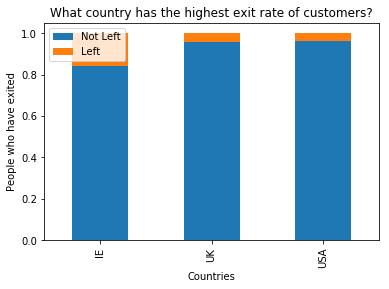

In [44]:
geography_table = pd.crosstab(df_master.geography, df_master.exited)
geography_table.div(geography_table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('What country has the highest exit rate of customers?')
plt.xlabel('Countries')
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc=2)
plt.savefig('percentage_geography_bar_chart')

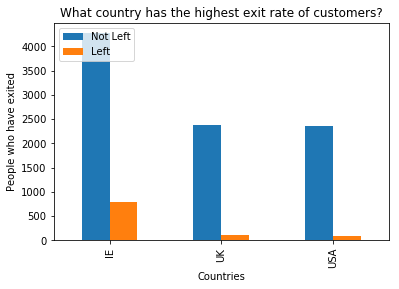

In [45]:
pd.crosstab(df_master.geography, df_master.exited).plot(kind='bar')
plt.title('What country has the highest exit rate of customers?')
plt.xlabel('Countries')
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc=2)
plt.savefig('geography_bar_chart')

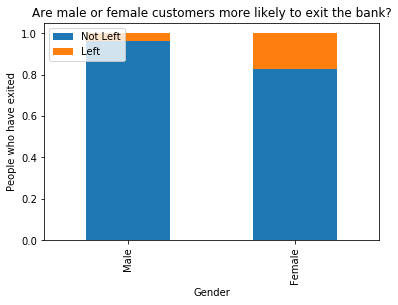

In [46]:
gender_table = pd.crosstab(df_master.gender, df_master.exited)
gender_table.div(gender_table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Are male or female customers more likely to exit the bank?')
plt.xlabel('Gender')
genderLabels = ['Male', 'Female']
plt.xticks([0,1],genderLabels)
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc=2)
plt.savefig('percentage_gender_bar_chart')

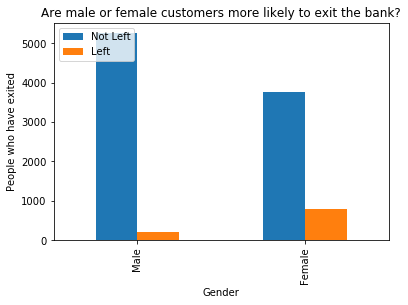

In [47]:
pd.crosstab(df_master.gender, df_master.exited).plot(kind='bar')
plt.title('Are male or female customers more likely to exit the bank?')
plt.xlabel('Gender')
genderLabels = ['Male', 'Female']
plt.xticks([0,1],genderLabels)
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc=2)
plt.savefig('gender_bar_chart')

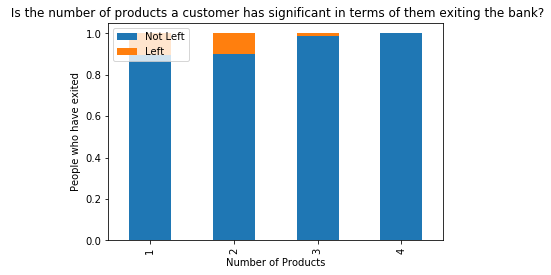

In [48]:
products_table = pd.crosstab(df_master.num_products, df_master.exited)
products_table.div(products_table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title(' Is the number of products a customer has significant in terms of them exiting the bank?')
plt.xlabel('Number of Products')
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc=2)
plt.savefig('percentage_products_bar_chart')

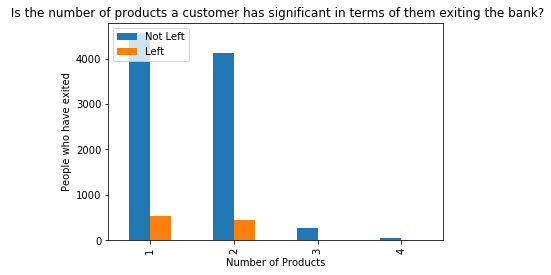

In [49]:
pd.crosstab(df_master.num_products, df_master.exited).plot(kind='bar')
plt.title(' Is the number of products a customer has significant in terms of them exiting the bank?')
plt.xlabel('Number of Products')
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc=2)
plt.savefig('products_bar_chart')

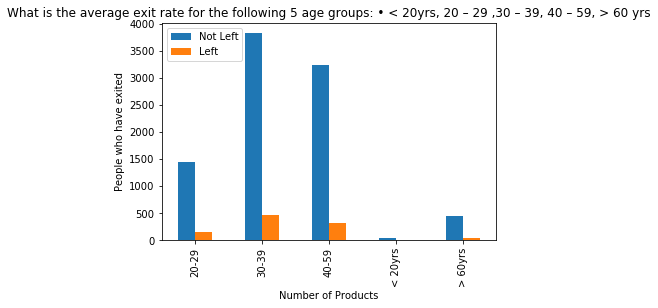

In [60]:
#What is the average exit rate for the following 5 age groups: • < 20yrs, 20 – 29 ,30 – 39, 40 – 59, > 60 yrs

df_master['ageGroups'] = pd.cut(df_master['age'], bins=[-1, 20, 30, 40, 60, 100], labels=['< 20yrs','20-29','30-39','40-59','> 60yrs'], right=False)
pd.crosstab(df_master.ageGroups, df_master.exited).plot(kind='bar')
plt.title('What is the average exit rate for the following 5 age groups: • < 20yrs, 20 – 29 ,30 – 39, 40 – 59, > 60 yrs')
plt.xlabel('Age Groups')
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc=2)
plt.savefig('percentage_age_bar_chart')

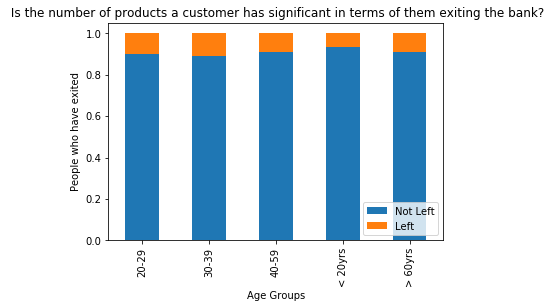

In [64]:
ages_table = pd.crosstab(df_master.ageGroups, df_master.exited)
ages_table.div(ages_table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title(' Is the number of products a customer has significant in terms of them exiting the bank?')
plt.xlabel('Age Groups')
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc='lower right')
plt.savefig('age_bar_chart')

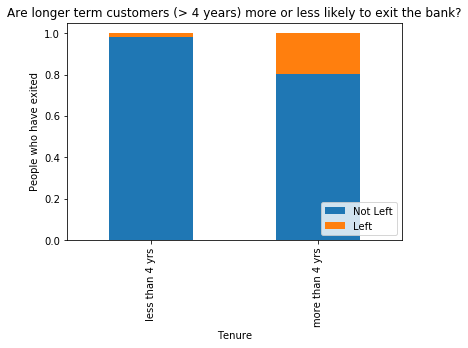

In [66]:
#Are longer term customers (> 4 years) more or less likely to exit the bank?
df_master['longerTermCustomers'] = np.where(df_master['tenure']>4, 'less than 4 yrs', 'more than 4 yrs')
tenure_table = pd.crosstab(df_master.longerTermCustomers, df_master.exited)
tenure_table.div(tenure_table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Are longer term customers (> 4 years) more or less likely to exit the bank?')
plt.xlabel('Tenure')
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc='lower right')
plt.savefig('percentage_tenure_bar_chart')

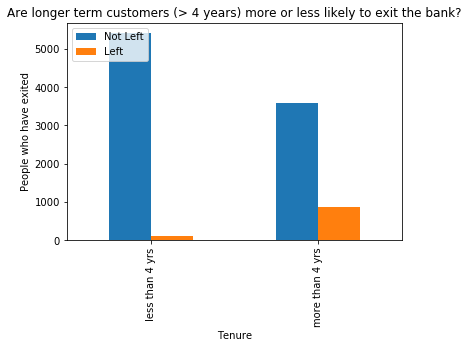

In [67]:
pd.crosstab(df_master.longerTermCustomers, df_master.exited).plot(kind='bar')
plt.title('Are longer term customers (> 4 years) more or less likely to exit the bank?')
plt.xlabel('Tenure')
plt.ylabel('People who have exited')
plt.legend(['Not Left', 'Left'],loc=2)
plt.savefig('tenure_bar_chart')

# Model the Data
1. Convert any categorical data columns to binary columns using the pandas dummy variables method (or any other method you choose)
2. Remove any columns that cannot be modelled!
3. Create model with training & test sets on all features. **Note: ** your test set should contain 30% of the total dataset (training = 70%)
4. Review the model, does it make sense?
5. Identify the single best feature to predict customre churn using your model
6. Identify the list of best feature(s) to predict customre churn using your model